# Cold-atom sensors: boosting signal to noise by 10x in high noise environments

**Using Q-CTRL robust Raman pulses to boost fringe contrast in tight-SWAP cold atom interferometers by an order of magnitude**

BOULDER OPAL enables you to create pulses for cold atom interferometers that are simultaneously robust to laser instability and thermal noise processes. Cold atom interferometers provide state-of-the-art gravitational and magnetic field sensitivity under laboratory conditions. However, when deployed in the field, their performance is limited by a combination of challenges arising from the laser instabilities, such as power, frequency, and phase fluctuations.

In these notes, you'll address this issue by designing control solutions for cold atom interferometers optimized for robustness against two simultaneous noise mechanisms:
* Laser intensity fluctuations often encountered in the field by processes such as fiber coupling jitter and thermal expansion of the atom cloud,
* The detuning processes, such as thermal momentum distribution of the atoms or the fluctuations in the laser frequency and phase.

The notebook is organized in three sections. First, you'll generate the Beam-Splitter (BS) and Mirror (M) pulses that are robust to noise in the laser amplitude and momentum distribution of the atom cloud. Next, you quantify the ability of the pulses to suppress the noise from both of the channels simultaneously. Finally, you'll simulate the Mach-Zehnder (MZ) atom interferometer based on Rb Raman transitions subject to amplitude laser fluctuations in conjunction with Doppler detuning given by the thermal momentum distribution. Here, you'll observe how under high noise conditions, the Q-CTRL robust pulses increase the fringe contrast by an order of magnitude compared to the primitive square pulses.

*This notebook contains preview features that are not currently available in BOULDER OPAL. Please [contact us](https://q-ctrl.com/contact) if you want a live demonstration for your hardware. Preview features are included through the package `qctrlcore`, which is not publicly available: cells with `qctrlcore` will not be executable.*

## Imports and initialization


In [1]:
# BOULDER OPAL
from qctrl import Qctrl

qctrl = Qctrl()

import copy
import time

import jsonpickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import qctrlcore as qc
import tensorflow as tf
from qctrlopencontrols import new_primitive_control
from qctrlvisualizer import plot_controls

# physical constants
h_bar = 1.054571817e-34
c_light = 3e8
k_b = 1.380649e-23

# Rb atom parameters
m_Rb = 86.9092 * 1.6605e-27
lamda = 780 * 1e-9  # m
k_avr = 2 * np.pi / lamda


# three-level matrices for the Raman Hamiltonian
identity3 = np.array(
    [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.complex
)

sigma_m13 = np.array(
    [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 0.0]], dtype=np.complex
)

sigma_m23 = np.array(
    [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0]], dtype=np.complex
)

# driving parameters
omega_eff = 2 * np.pi * 4.0 * 10e3  # Hz
# detunings parameters
delta = 0  # two-photon
DELTA = 10e9  # one-photon

# dicts used to hold controls for M and BS pulses
pi_half_pulse_controls = {}
pi_pulse_controls = {}


# if True, longer optimization & simulation results will be loaded from file
read_flag = True
# save to/load from
data_dir = "./resources/cold-atom-sensors-boosting-signal-to-noise-by-10x-in-high-noise-environments/"
Optimized_BS_pulse_file = data_dir + "AtomSensing_Optimized_BS_pulse"
Optimized_M_pulse_file = data_dir + "AtomSensing_Optimized_M_pulse"
Fringe_signals_file = data_dir + "AtomSensing_Fringe_signals"


# helper functions
def three_level_controls_from_Open_pulse(pulse):
    """
    This function converts Open Controls pulses designed for 2 level systems and maps them onto the 3 level
    Raman Hamiltonian, achieving equivalent evolution of the two ground states.
    """
    # move from effective Rabi rate to two equal laser drives rates
    omega_1 = np.sqrt(pulse.rabi_rates / 2 * DELTA)
    omega_2 = pulse.rabi_rates / 2 * DELTA / omega_1
    # assign half of effective phase to each drive
    phasors_1 = omega_1 * np.exp(1j * (pulse.azimuthal_angles / 2))
    phasors_2 = omega_2 * np.exp(-1j * (pulse.azimuthal_angles / 2))
    # place pulse segments into the required dictionary control format for qctrlcore
    duration = np.sum(pulse.durations)

    return {
        "Omega_1": [
            {"duration": d, "value": v} for d, v in zip(pulse.durations, phasors_1)
        ],
        "Omega_2": [
            {"duration": d, "value": v} for d, v in zip(pulse.durations, phasors_2)
        ],
    }


def run_optimization(duration, target_operator):
    """
    This function specifies the control drive variables and the cost function for the optimizer.
    It outputs the final cost and the optimized controls.
    """
    number_of_segments = 256  # number of pulse segments
    number_of_optimization_variables = 128
    optimization_count = 20  # number of optimization runs
    omega_limit = omega_eff / np.sqrt(2)  # maximum effective Rabi rate
    cutoff_frequency = 4 * omega_eff
    shift_limit = 5 * omega_eff  # p/m limit on the freq. shift control

    # define Pauli matrices for 2 level optimisation
    sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
    sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
    sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=np.complex)

    with qctrl.create_graph() as graph:

        # set up for drive controls

        # create I & Q variables
        I_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables,
            lower_bound=-omega_limit,
            upper_bound=omega_limit,
        )
        Q_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables,
            lower_bound=-omega_limit,
            upper_bound=omega_limit,
        )

        # create I & Q signals
        I_signal = qctrl.operations.pwc_signal(values=I_values, duration=duration)
        Q_signal = qctrl.operations.pwc_signal(values=Q_values, duration=duration)

        # apply the sinc filter to smooth and bandlimit the pulses (if desired)
        sinc_filter = qctrl.operations.sinc_integral_function(cutoff_frequency)

        I_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=I_signal, kernel_integral=sinc_filter
        )
        Q_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=Q_signal, kernel_integral=sinc_filter
        )

        # re-discretize signal
        I_signal = qctrl.operations.discretize_stf(
            stf=I_signal_filtered,
            duration=duration,
            segments_count=number_of_segments,
            name="i",
        )
        Q_signal = qctrl.operations.discretize_stf(
            stf=Q_signal_filtered,
            duration=duration,
            segments_count=number_of_segments,
            name="q",
        )

        # set up drive signal for export
        drive_signal = qctrl.operations.pwc_signal(
            values=qctrl.operations.complex_value(I_signal.values, Q_signal.values),
            duration=duration,
            name="$\omega$",
        )

        # set up for shift controls

        # create frequency shift variables
        S_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables,
            lower_bound=-shift_limit,
            upper_bound=shift_limit,
        )

        # create S signals
        S_signal = qctrl.operations.pwc_signal(values=S_values, duration=duration)

        # apply the sinc filter
        sinc_filter = qctrl.operations.sinc_integral_function(cutoff_frequency)

        S_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=S_signal, kernel_integral=sinc_filter
        )

        # re-discretize signal
        S_signal = qctrl.operations.discretize_stf(
            stf=S_signal_filtered,
            duration=duration,
            segments_count=number_of_segments,
            name="$\zeta$",
        )

        # set up multiple quasi-static Hamiltonian terms

        # detuning (delta) noise terms (constant for all points)
        detuning_noise = qctrl.operations.constant_pwc_operator(
            duration=duration, operator=sigma_z * 2.0 * np.pi / duration
        )

        # shift term (constant for all points)
        S_term = qctrl.operations.pwc_operator(signal=S_signal, operator=sigma_z / 2.0)

        # the 2D grid of quasi-static points in the format: [delta, beta, weight]
        quasistatic_points = [
            [-0.2, 0.4, 0.07],
            [0.0, 0.4, 0.1],
            [+0.2, 0.4, 0.07],
            [-0.2, 0.25, 0.21],
            [0.0, 0.25, 1.0],
            [+0.2, 0.25, 0.21],
            [-0.3, 0.0, 0.7],
            [0.0, 0.0, 7.0],
            [+0.3, 0.0, 0.7],
            [-0.2, -0.25, 0.21],
            [0.0, -0.25, 1.0],
            [+0.2, -0.25, 0.21],
            [-0.2, -0.4, 0.07],
            [0.0, -0.4, 0.1],
            [+0.2, -0.4, 0.07],
        ]

        quasistatic_infidelities = []

        # loop over all points to generate infidelity for each quasi-static Hamiltonian
        for point in quasistatic_points:

            relative_delta_pt = point[0]
            beta_pt = point[1]
            weight_pt = point[2]

            # create quasi-static delta terms
            delta_term = qctrl.operations.constant_pwc_operator(
                duration=duration,
                operator=sigma_z / 2.0 * relative_delta_pt * omega_limit,
            )

            # create Hamiltonian drive terms
            I_term = qctrl.operations.pwc_operator(
                signal=qctrl.operations.pwc_signal(
                    values=I_signal.values * (1 + beta_pt), duration=duration
                ),
                operator=sigma_x / 2.0,
            )

            Q_term = qctrl.operations.pwc_operator(
                signal=qctrl.operations.pwc_signal(
                    values=Q_signal.values * (1 + beta_pt), duration=duration
                ),
                operator=sigma_y / 2.0,
            )

            # combine into net drive term
            drive_term = qctrl.operations.pwc_sum([I_term, Q_term])

            # total Hamiltonian corresponding quasi-static point
            quasistatic_Hamiltonian = qctrl.operations.pwc_sum(
                [drive_term, S_term, delta_term]
            )

            # create infidelity for the quasi-static points
            quasistatic_infidelity = qctrl.operations.infidelity_pwc(
                hamiltonian=quasistatic_Hamiltonian,
                target_operator=qctrl.operations.target(target_operator),
                noise_operators=[detuning_noise, drive_term],
            )

            # infidelities corresponding to quasi-static points
            quasistatic_infidelities.append(weight_pt * quasistatic_infidelity)

        # create the total cost
        quasistatic_cost = qctrl.operations.sum(quasistatic_infidelities, name="cost")

    # run optimization
    return qctrl.functions.calculate_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["$\omega$", "$\zeta$"],
        optimization_count=optimization_count,
    )


def three_level_controls_from_2level_optimized_result(optimized_result):
    """
    This function converts optimized controls for the effective two-level systems to the three-level
    Raman Hamiltonian system.
    """
    controls = {}

    # drive for a 2 level system translates onto sigma_12 and sigma_23 drives
    if "$\omega$" in optimized_result:

        effective_phasors = np.array(
            [segment["value"] for segment in optimized_result["$\omega$"]]
        )
        durations = np.array(
            [segment["duration"] for segment in optimized_result["$\omega$"]]
        )

        omega_1 = np.sqrt(np.abs(effective_phasors) / 2 * DELTA)
        omega_2 = np.abs(effective_phasors) / 2 * DELTA / omega_1

        # assign half of effective phase to each drive
        phases = np.angle(effective_phasors)
        phasors_1 = omega_1 * np.exp(-1j * phases / 2)
        phasors_2 = omega_2 * np.exp(+1j * phases / 2)

        controls["Omega_1"] = [
            {"duration": d, "value": v} for d, v in zip(durations, phasors_1)
        ]
        controls["Omega_2"] = [
            {"duration": d, "value": v} for d, v in zip(durations, phasors_2)
        ]

    # shift only for a 2 level system translated onto sigma_12 and sigma_23 drives
    if "$\zeta$" in optimized_result:

        S_values = np.array(
            [segment["value"] for segment in optimized_result["$\zeta$"]]
        )
        shift_durations = np.array(
            [segment["duration"] for segment in optimized_result["$\zeta$"]]
        )

        controls["zeta"] = [
            {"duration": d, "value": v} for d, v in zip(shift_durations, S_values)
        ]

    return controls


def convert_to_core_control_format(controls):
    """
    This function converts controls to the `core` compatible format.
    """
    drives = []
    drifts = []
    shifts = []
    # drive for a 2 level system translates onto sigma_12 and sigma_23 drives
    if ("Omega_1" in controls) and ("Omega_2" in controls):

        # output as core ctrls
        drives = [
            {
                "operator": qc.NonHermitianOperator(sigma_m13),
                "control": [
                    qc.ComplexSegment(s["duration"], s["value"])
                    for s in controls["Omega_1"]
                ],
            },
            {
                "operator": qc.NonHermitianOperator(sigma_m23),
                "control": [
                    qc.ComplexSegment(s["duration"], s["value"])
                    for s in controls["Omega_2"]
                ],
            },
        ]

    # shift only for a 2 level system translated onto sigma_12 and sigma_23 drives
    if "zeta" in controls:

        shifts = [
            {
                "operator": qc.HermitianOperator(
                    np.array(
                        [[-1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]],
                        dtype=np.complex,
                    )
                    / 2.0
                ),
                "control": [
                    qc.ComplexSegment(s["duration"], s["value"])
                    for s in controls["zeta"]
                ],
            }
        ]
    return {
        "drives": drives,
        "drifts": drifts,
        "shifts": shifts,
    }


def unitary_from_drives(controls, phi, beta, DELTA=DELTA, delta=delta):
    """
    This function takes the pulse controls, constructs the Hamiltonian evolution around an axis given by phase offset
    phi for the given amplitude noise beta. The momentum/detuning noises are provided via delta and DELTA parameters.
    """
    drives = copy.deepcopy(controls["drives"])
    drifts = copy.deepcopy(controls["drifts"])
    shifts = copy.deepcopy(controls["shifts"])
    # compute the total pulse duration
    duration = np.max(
        [
            np.sum([segment.duration for segment in control["control"]])
            for category in [*controls]
            if isinstance(controls[category], list)
            for control in controls[category]
            if "control" in control
        ]
    )
    # set up the two laser drives
    drives[0]["control"] = [
        qc.ComplexSegment(s.duration, np.exp(1j * phi / 2) * s.value)
        for s in drives[0]["control"]
    ]
    drives[1]["control"] = [
        qc.ComplexSegment(s.duration, np.exp(-1j * phi / 2) * s.value)
        for s in drives[1]["control"]
    ]
    # add noise to drive control dictionary
    for idx, drive in enumerate(drives):
        drives[idx]["noise"] = beta
    # set up the frequency drifts (detunings)
    drifts = [
        {
            "operator": qc.HermitianOperator(
                np.array(
                    [[-DELTA, 0.0, 0.0], [0.0, -DELTA - delta, 0.0], [0.0, 0.0, 0.0]],
                    dtype=np.complex,
                )
            )
        }
    ]
    # run the qctrlcore unitary evolution routine
    simulation_result = qc.calculate_static_offset_unitary_evolution(
        duration=duration,
        drives=drives,
        shifts=shifts,
        drifts=drifts,
    )

    return simulation_result[-1]["evolution_operator"].operator


def pulse_1D_quasi_static_scan(controls, target, betas, del_pz_coefficients):
    """
    This function performes the quasitatic scan against pairs of beta and del_pz_coefficients.
    betas, del_pz_coefficients lists need to be of the same lenght.
    """
    unitaries = [
        unitary_from_drives(
            controls,
            0,
            b,
            DELTA=DELTA + pz * k_avr / m_Rb,
            delta=-2 * pz * k_avr / m_Rb,
        )
        for b, pz in zip(betas, del_pz_coefficients)
    ]

    infidelities = [
        1
        - qc.calculate_operational_fidelity(
            actual_operator=u, target_operator=np.matmul(target, np.diag([1, 1, 0]))
        )["fidelity"]
        for u in unitaries
    ]
    return infidelities


def pulse_2D_quasi_static_scan(controls, phi, target, betas, del_pz_coefficients):
    """
    This function computes the 2D quasi-static scan for all combinations of betas and del_pz_coefficients.
    """
    X, Y = np.meshgrid(del_pz_coefficients, betas)

    U = [
        [
            unitary_from_drives(
                controls,
                phi,
                y,
                DELTA=DELTA + x * k_avr / m_Rb,
                delta=-2 * x * k_avr / m_Rb,
            )
            for x, y in zip(Xr, Yr)
        ]
        for Xr, Yr in zip(X, Y)
    ]
    infidelities = [
        [
            1
            - qc.calculate_operational_fidelity(
                actual_operator=u, target_operator=np.matmul(target, np.diag([1, 1, 0]))
            )["fidelity"]
            for u in Ur
        ]
        for Ur in U
    ]

    return [X, Y, infidelities]


# JSON based r/w helper functions, type independent
def save_var(file_name, var):
    # Save a single var to a file using json
    f = open(file_name, "w+")
    to_write = jsonpickle.encode(var)
    f.write(to_write)
    f.close()


def load_var(file_name):
    # Load a var from a json file
    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded

## Creating robust Q-CTRL pulses for atom interferometry

Here, you'll create the set of Raman pulses optimized to simultaneously suppress against two pathways in which physical noise channels feed into the Raman Hamiltonian, namely detuning and Rabi rate variations.

### Interferometer model

Consider a three-level atomic system of mass $M$ with two hyperfine ground states $|1\rangle$ and $|2\rangle$ and a third excited state $|3\rangle$ with transition frequencies given by $\omega_{13}$ ($|1\rangle\leftrightarrow|3\rangle$), $\omega_{23}$ ($|2\rangle\leftrightarrow|3\rangle$), and $\omega_{12}$ ($|1\rangle\leftrightarrow|2\rangle$). The system is driven by two counterpropagating laser beams in the Raman configuration with frequencies $\omega_{1L}$ and $\omega_{2L}$, with wave vectors $k_{1L}$ and $k_{2L}$, respectively.

The corresponding system Hamiltonian for a single momentum family $p$ ($|1,p-\hbar k_{1L}\rangle$, $|2, p+\hbar k_{2L}\rangle$ and $|3, p\rangle$) is given as follows (see [Moler, Weiss, Kasevich & Chu](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.45.342)):

\begin{align*}
H = \begin{pmatrix}
-\Delta & 0 & \Omega_1\\
0 & -(\Delta + \delta) & \Omega_2\\
\Omega_1^* & \Omega_2^* & 0
\end{pmatrix},
\end{align*}

where $\Omega_1$ and $\Omega_2$ are the Rabi rates associated with $|1\rangle\leftrightarrow|3\rangle$ and $|2\rangle\leftrightarrow|3\rangle$ optical transitions, while $\Delta$ and $\delta$ are the one-photon and two-photon detunings:

\begin{align*}
\Delta &= \frac{p k_{1L}}{M} - \frac{\hbar k_{1L}^2}{2M} +\omega_{13} -\omega_{1L},\\
\delta &= -\frac{p(k_{1L}+k_{2L})}{M} + \frac{\hbar k_{1L}^2}{2M} -\frac{\hbar k_{2L}^2}{2M} -\omega_{12} +\omega_{1L}-\omega_{2L}.
\end{align*}

Now, define the average frequency $\omega$ and the average wavevector $k = \omega/c$ as constants, such that the frequency difference between the two laser beams is captured by the single control parameter $\zeta$:

\begin{align*}
\omega_{1L} & = \omega + \frac{\zeta}{2},\\
\omega_{2L} & = \omega - \frac{\zeta}{2}.
\end{align*}

In the regime of interest, the one-photon transitions are significantly detuned ($\Delta\gg|\Omega_1|,|\Omega_2|,\delta$), and we can adiabatically eliminate the excited state. Therefore, the effective two-level Hamiltonian for the two internal states $|1,p-\hbar k_{1L}\rangle$ and $|2 , p+\hbar k_{2L}\rangle$ becomes:

\begin{align*}
H_{\rm eff} = \frac{1}{2} \begin{pmatrix}
\zeta & |\Omega_{\rm eff}|e^{i\phi}\\
|\Omega_{\rm eff}|e^{-i \phi} & - \zeta\\
\end{pmatrix},
\end{align*}

where the $\Omega_{\rm eff}$ is effective Rabi rate an $\phi$ the relative phase between the laser beams:

\begin{align*}
&\Omega_{\rm eff} = \frac{\Omega_1\Omega_2^*}{2\Delta}, \\
&\phi = {\rm arg}(\Omega_1) - {\rm arg}(\Omega_2).\\
\end{align*}

Let's introduce the noise channels on which you'll be focusing. The thermal distribution of atomic momenta in the direction of the laser (z-axis), $\partial p_z$, and the fluctuations in the laser power characterized by the parameter $\beta$.

The momentum variations couple via the detunings terms, $\Delta\rightarrow \Delta + \frac{\partial p_z k}{2M}$ and $\delta\rightarrow \delta - \frac{\partial p_z k}{M}$, while the laser fluctuations couple multiplicatively via the Rabi rate as $\Omega_\text{eff}\rightarrow(1+\beta)\Omega_\text{eff}$, for $\beta\in [-1,\infty)$. Therefore, the effective two-level Hamiltonian is:

\begin{align*}
H_{\rm eff} = \frac{1}{2} \begin{pmatrix}
\zeta -\frac{\partial p_z k}{M} & (1+\beta)|\Omega_{\rm eff}|e^{i\phi}\\
(1+\beta)|\Omega_{\rm eff}|e^{-i \phi} & - \zeta +\frac{\partial p_z k}{M} \\
\end{pmatrix}.
\end{align*}

### The robust Mirror and Beam-Splitter pulses

You'll use the effective two-level Hamiltonian to generate the robust control parameters $\Omega_{\rm eff}$, $\zeta$ and $\phi$ for the specified target operation, given pulse duration and the number of segments. 

To optimize the pulses, you can employ our custom cost function provided below. It features a grid of quasi-static noise "points" that pave an extensive region of the 2D noise space formed by the two noise channels: the laser amplitude fluctuations and thermal detuning. Each point describes the system's Hamiltonian that has been quasi-statically offset by a pair of noise terms ($\partial p_z$, $\beta$). The cost function is the weighted sum of the control's infidelity and its filter function response across all points. Minimizing this cost function ensures that the control pulse performs its target operation with high fidelity when $\partial p_z$ and $\beta$ fall within a certain radius from a quasi-static point. By placing the points in a grid of sufficient spacing, you define a custom region of robustness across the noise amplitude landscape. The approach is well suited to sensing applications in high amplitude noise environments. 

After you generate the robust Beam-Splitter and Mirror pulses controls, you'll convert them to the full three-level Raman controls for analysis in further sections. Plotting of the the control parameters is done via [Q-CTRL Visualizer Python package](https://docs.q-ctrl.com/boulder-opal/references/qctrl-visualizer/).

The Beam-Splitter pulse:


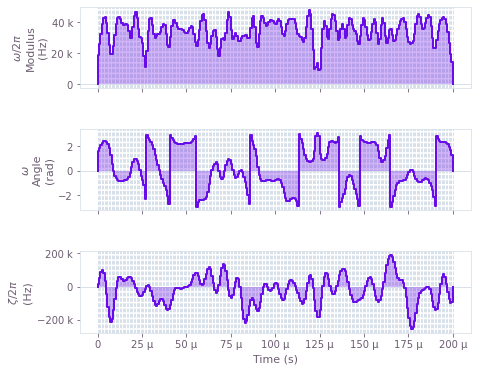

The Mirror pulse:


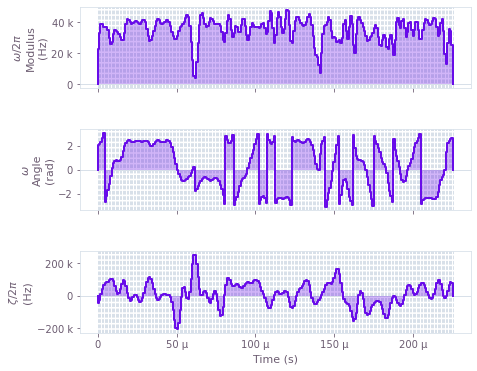

In [2]:
optimization_scheme = "Q-CTRL"

# duration of one effective Rabi cycle period
s = 2 * np.pi / omega_eff

# BS pulse
print("The Beam-Splitter pulse:")
pi_half_duration = 8 * s  # duration of the BS pulse
pi_half_target_operator = np.array(
    [[np.sqrt(2) / 2, -1j * np.sqrt(2) / 2], [-1j * np.sqrt(2) / 2, np.sqrt(2) / 2]],
    dtype=np.complex,
)
if not read_flag:
    print("**Optimizing pulse**")
    start_time = time.time()
    # the optimizaiton routine
    results = run_optimization(pi_half_duration, pi_half_target_operator)
    save_var(Optimized_BS_pulse_file, results)
    print("run (in min):", (time.time() - start_time) / 60.0)
else:
    results = load_var(Optimized_BS_pulse_file)

# store results to the three-level controls dict
pi_half_pulse_controls[
    optimization_scheme
] = three_level_controls_from_2level_optimized_result(results.output)

# plot controls
combined_controls = {**results.output}
plot_controls(plt.figure(), combined_controls)
plt.show()

# M pulse
print("The Mirror pulse:")
pi_duration = 9 * s  # duraiton of the M pulse
pi_target_operator = np.array([[0.0, -1j], [-1j, 0.0]], dtype=np.complex)
if not read_flag:
    print("**Optimizing pulse**")
    start_time = time.time()
    # the optimizaiton routine
    results = run_optimization(pi_duration, pi_target_operator)
    save_var(Optimized_M_pulse_file, results)
    print("run (in min):", (time.time() - start_time) / 60.0)
else:
    results = load_var(Optimized_M_pulse_file)
# store results to the three-level controls dict
pi_pulse_controls[
    optimization_scheme
] = three_level_controls_from_2level_optimized_result(results.output)

# plot controls
combined_controls = {**results.output}
plot_controls(plt.figure(), combined_controls)
plt.show()

Plotted are the three control variables $\Omega_{\rm eff}$, $\phi$ and $\zeta$ as a function of time for the robust Beam-Splitter and Mirror pulses. Note that the robust pulses can be build based on the specific selection of controls you use to your setup. For example, the control could only utilize a single parameter such as $\phi$ ($\Omega_{\rm eff}=const.$, $\zeta=0$) or a combination of any two parameters. Filtering can be natively incorporated into the optimization process. For example, the pulses shown have a bandpass (sinc) filter with a cutoff of $4\Omega_{\rm eff}$.

## Robustness verification with quasi-static scans

You can quantify the robustness of the control pulses by computing the infidelity of the three-level Raman unitary evolution as a function of the noise amplitude. The noise is treated in a quasi-static fashion over the duration of the pulse.

The performance of the robust pulses against the primitive square pulses will be compared for the following noise channels:
* The laser amplitude noise $\beta$,
* The atom's momentum deviation $\partial p_z$,
* The correlated combinations of noise from the two channels ($\partial p_z$,$\beta$).

You'll then benchmark the performance of the Q-CTRL robust pulses against the primitive square pulses most often used in cold atom interferometers. The square pulses are imported from [Open Controls](https://q-ctrl.com/products/open-controls/), and converted from the standard two-level format to the three-level Raman controls in order to form the Beam-Splitter ($\pi/2$) and Mirror ($\pi$) pulses.

In [3]:
#  generate controls from open pulses and add to the list of pulse controls
scheme = "primitive"

print(scheme, " Mirror pulse created")
pi_pulse = new_primitive_control(
    rabi_rotation=np.pi,
    azimuthal_angle=0,
    maximum_rabi_rate=omega_eff,
)
# store the result in the control dict
pi_pulse_controls[scheme] = three_level_controls_from_Open_pulse(pi_pulse)

print(scheme, " Beam-Splitter pulse created")
pi_half_pulse = new_primitive_control(
    rabi_rotation=np.pi / 2,
    azimuthal_angle=0,
    maximum_rabi_rate=omega_eff,
)
# store the result in the control dict
pi_half_pulse_controls[scheme] = three_level_controls_from_Open_pulse(pi_half_pulse)

primitive  Mirror pulse created
primitive  Beam-Splitter pulse created


### Robustness to laser intensity fluctuations

Here the infidelity of the Mirror and Beam-Splitter pulses is computed as a function of the laser fluctuations parameter $\beta$.

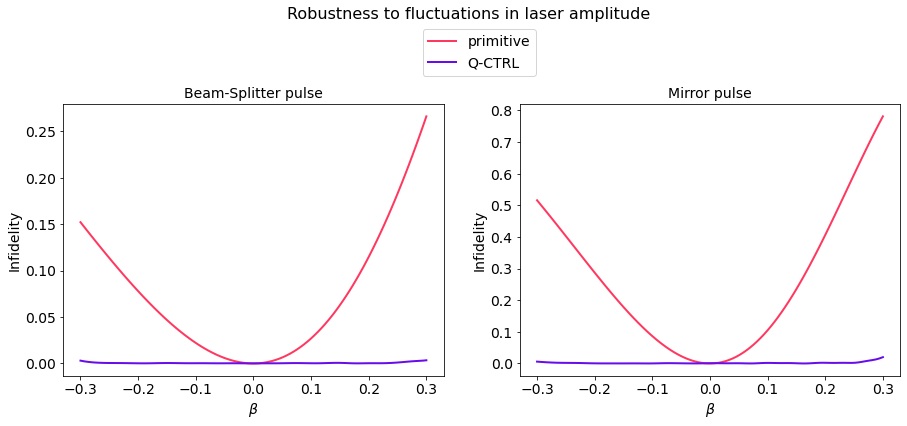

In [4]:
# set the three-level unitary target operators for the BS and M pulses
pi_half_target_operator = np.array(
    [
        [np.sqrt(2) / 2, 1j * np.sqrt(2) / 2, 0.0],
        [1j * np.sqrt(2) / 2, np.sqrt(2) / 2, 0.0],
        [0.0, 0.0, 1.0],
    ],
    dtype=np.complex,
)

pi_target_operator = np.array(
    [[0.0, 1j, 0.0], [1j, 0.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.complex
)

# quasi-static scan coefficients
betas = np.linspace(-0.3, 0.3, 100)
del_pz_coefficients = 0 * betas

# pulse schemes
schemes = ["primitive", "Q-CTRL"]
colours = ["#FF3860", "#680CEA"]

gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle("Robustness to fluctuations in laser amplitude", fontsize=16, y=1.15)

# BS pulse quasi_static_scan
ax = fig.add_subplot(gs[0])
ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_title("Beam-Splitter pulse", fontsize=14)
ax.tick_params(labelsize=14)

for idx, scheme in enumerate(schemes):
    infidelities = pulse_1D_quasi_static_scan(
        convert_to_core_control_format(pi_half_pulse_controls[scheme]),
        pi_half_target_operator,
        betas,
        del_pz_coefficients,
    )

    ax.plot(betas, infidelities, "-", linewidth=2, label=scheme, color=colours[idx])

# M pulse quasi_static_scan
ax = fig.add_subplot(gs[1])
ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_title("Mirror pulse", fontsize=14)
ax.tick_params(labelsize=14)

for idx, scheme in enumerate(schemes):
    infidelities = pulse_1D_quasi_static_scan(
        convert_to_core_control_format(pi_pulse_controls[scheme]),
        pi_target_operator,
        betas,
        del_pz_coefficients,
    )
    ax.plot(betas, infidelities, "-", linewidth=2, label=scheme, color=colours[idx])

ax.legend(loc="best", bbox_to_anchor=(0.06, 1.3), fontsize=14)
plt.show()

Depicted is the pulse infidelity as the function of the laser amplitude fluctuation $\beta$. Note, in contrast to primitive square pulses, the infidelity of optimized pulses stays close to zero for an extensive range of laser power variations up to around $\pm30\%$. This is significant as the laser fluctuations of this magnitude are encountered, e.g. in cloud expansion across the laser beams and impact of vibrations on fiber coupling in field-deployed interferometers.

### Robustness to atom momentum variations

Next, compute the infidelity of the Mirror and Beamsplitter pulses as a function of the momentum variation of the atom $\partial p_z$.

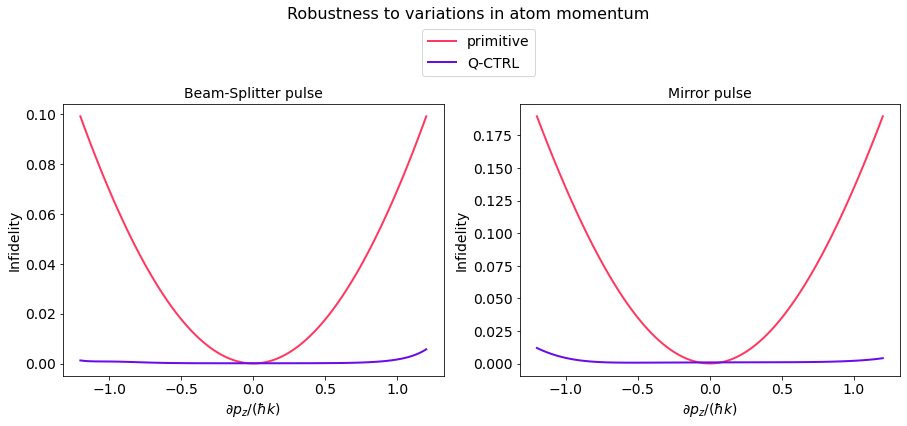

In [5]:
del_pz_coefficients = (h_bar * k_avr) * np.linspace(-1.2, 1.2, 100)
betas = 0 * del_pz_coefficients

gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle("Robustness to variations in atom momentum", fontsize=16, y=1.15)


# BS pulse quasi_static_scan
ax = fig.add_subplot(gs[0])
ax.set_xlabel(r"$\partial p_z/(\hbar k)$", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_title("Beam-Splitter pulse", fontsize=14)
ax.tick_params(labelsize=14)
for idx, scheme in enumerate(schemes):
    infidelities = pulse_1D_quasi_static_scan(
        convert_to_core_control_format(pi_half_pulse_controls[scheme]),
        pi_half_target_operator,
        betas,
        del_pz_coefficients,
    )

    ax.plot(
        del_pz_coefficients / (h_bar * k_avr),
        infidelities,
        "-",
        linewidth=2,
        label=scheme,
        color=colours[idx],
    )

# M pulse quasi_static_scan
ax = fig.add_subplot(gs[1])
ax.set_xlabel(r"$\partial p_z/(\hbar k)$", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_title("Mirror pulse", fontsize=14)
ax.tick_params(labelsize=14)
for idx, scheme in enumerate(schemes):
    infidelities = pulse_1D_quasi_static_scan(
        convert_to_core_control_format(pi_pulse_controls[scheme]),
        pi_target_operator,
        betas,
        del_pz_coefficients,
    )

    plt.plot(
        del_pz_coefficients / (h_bar * k_avr),
        infidelities,
        "-",
        linewidth=2,
        label=scheme,
        color=colours[idx],
    )


ax.legend(loc="best", bbox_to_anchor=(0.06, 1.3), fontsize=14)
plt.show()

Plotted is the pulse infidelity as a function of deviation in the atom's momentum $\partial p_z$.  Here, you can also see that, in contrast to primitive square pulses, the infidelity of optimized pulses stays flat for a wide range of momentum variations, up to around $\pm1k\hbar$. This is significant, as the given range overshoots typical experimental thermal spread in the atom clouds.

### Robustness to noise in simultaneous channels

In the previous two sections, we focused on single-channel noise. However, the pulses are optimized to provide robustness against simultaneous noise channels. Using Mirror pulses as an example, you can test the performance of the pulses when both noise channels are present, by representing the infidelity on a 2D plot formed by ($\partial p_z$,$\beta$) axis.

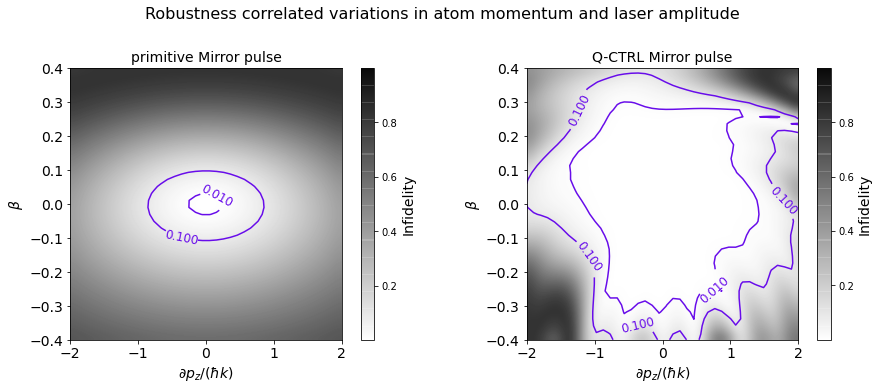

In [6]:
# momentum noise coefficients
pz_coefficients = h_bar * k_avr * np.linspace(-2, 2, 40)
# laser noise coefficients beta
betas = np.linspace(-0.4, 0.4, 40)

# set up for 2D plot
gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle(
    "Robustness correlated variations in atom momentum and laser amplitude",
    fontsize=16,
    y=1.05,
)

# the primitive square Mirror pulses
scheme = schemes[0]
(X, Y, Z) = pulse_2D_quasi_static_scan(
    convert_to_core_control_format(pi_pulse_controls[scheme]),
    0,
    pi_target_operator,
    betas,
    pz_coefficients,
)
X = X / (h_bar * k_avr)

# plot 2D contours
ax = fig.add_subplot(gs[0])
ax.set_title(scheme + " Mirror pulse", fontsize=14)
ax.set_ylabel(r"$\beta$", fontsize=14)
ax.set_xlabel(r"$\partial p_z/(\hbar k)$", fontsize=14)
ax.tick_params(labelsize=14)
contours = ax.contour(X, Y, Z, levels=[0.01, 0.1], colors="#680CEA")
ax.clabel(contours, inline=True, fontsize=12)
cmap_reversed = plt.cm.get_cmap("gray").reversed()

plt.imshow(
    Z,
    extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)],
    origin="lower",
    cmap=cmap_reversed,
    alpha=0.8,
    aspect=np.abs((np.min(X) - np.max(X)) / (np.min(Y) - np.max(Y))),
    interpolation="bicubic",
)
cbar = plt.colorbar()
cbar.set_label("Infidelity", fontsize=14)

# the optimized Mirror pulses
scheme = schemes[1]
(X, Y, Z) = pulse_2D_quasi_static_scan(
    convert_to_core_control_format(pi_pulse_controls[scheme]),
    0,
    pi_target_operator,
    betas,
    pz_coefficients,
)
X = X / (h_bar * k_avr)

# plot 2D contours
ax = fig.add_subplot(gs[1])
ax.set_title(scheme + " Mirror pulse", fontsize=14)
ax.set_ylabel(r"$\beta$", fontsize=14)
ax.set_xlabel(r"$\partial p_z/(\hbar k)$", fontsize=14)
ax.tick_params(labelsize=14)
contours = ax.contour(
    X,
    Y,
    Z,
    levels=[
        0.01,
        0.1,
    ],
    colors="#680CEA",
)
ax.clabel(contours, inline=True, fontsize=12)

cmap_reversed = plt.cm.get_cmap("gray").reversed()

plt.imshow(
    Z,
    extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)],
    origin="lower",
    cmap=cmap_reversed,
    alpha=0.8,
    aspect=np.abs((np.min(X) - np.max(X)) / (np.min(Y) - np.max(Y))),
    interpolation="bicubic",
)
cbar = plt.colorbar()
cbar.set_label("Infidelity", fontsize=14)

plt.show()

Plotted is the infidelity of the Mirror pulse as a function of both $\partial p_z$ and $\beta$.
To establish a relative comparison of the pulses' respective performance over the noise correlation space, observe that the area of the 0.01 infidelity contour of the robust pulses is around 30 times larger compared to the primitive square pulses. This is important experimentally because the atom's momentum and the laser amplitude variation form a highly correlated process during the thermal expansion of the atom cloud.

## Improving interferometer fringe contrast with robust pulses

In order to demonstrate the impact of optimized pulses on atom interferometry, you will simulate a Mach-Zender interferometer configuration for the atom cloud of typical thermal distribution under a significant laser amplitude noise.

### Noise model

The laser amplitude fluctuation process will be subject to a Gaussian distribution with the relatively broad standard deviation of $\sigma(\beta)=0.3$ reflective of the high noise environments. The thermal momentum noise process will have a standard deviation of $\sigma(\partial p_z) = 0.2\hbar k$, consistent with the thermal spread readily achievable in cold atom clouds.

In [7]:
ensemble_size = 2000  # the nuber of times we sample from the noise processes

# laser fluctuations
beta_ensembles = {}
for scheme in schemes:
    beta_ensembles[scheme] = []
# beta noise distribution
bets_sigma = 0.35
# set beta ensemble for each pulse
pulse_sequence = ["BS", "M", "BS"]
for scheme in schemes:
    for _ in pulse_sequence:

        betas_for_pulse = np.random.normal(0, bets_sigma, ensemble_size)
        betas_for_pulse[betas_for_pulse < -1] = -1
        beta_ensembles[scheme].append(betas_for_pulse)

# thermal momentum noise
del_pz_sigma = 0.2 * h_bar * k_avr  # momentum width
pz0 = np.random.normal(0, del_pz_sigma, ensemble_size)
# compute ensemble of detunings
deltas = -2 * pz0 * k_avr / m_Rb
DELTAS = DELTA + pz0 * k_avr / m_Rb

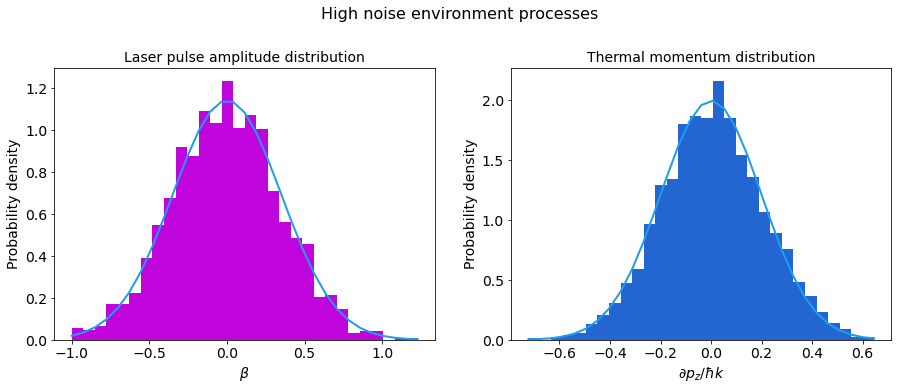

In [8]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle("High noise environment processes", fontsize=16, y=1.05)


# plot laser noise
ax = fig.add_subplot(gs[0])
ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel("Probability density", fontsize=14)
ax.set_title("Laser pulse amplitude distribution", fontsize=14)
ax.tick_params(labelsize=14)
count, bins, ignored = ax.hist(
    beta_ensembles["primitive"][0], 30, density=True, color="#BF04DC"
)
ax.plot(
    bins,
    1
    / (bets_sigma * np.sqrt(2 * np.pi))
    * np.exp(-((bins) ** 2) / (2 * (bets_sigma) ** 2)),
    linewidth=2,
    color="#209CEE",
)

# plot momentum distibution
ax = fig.add_subplot(gs[1])
ax.set_xlabel(r"$\partial p_z/\hbar k$", fontsize=14)
ax.set_ylabel("Probability density", fontsize=14)
ax.set_title("Thermal momentum distribution", fontsize=14)
ax.tick_params(labelsize=14)
count, bins, ignored = plt.hist(
    pz0 / (h_bar * k_avr), 30, density=True, color="#2366D1"
)
plt.plot(
    bins,
    1
    / (del_pz_sigma / (h_bar * k_avr) * np.sqrt(2 * np.pi))
    * np.exp(-((bins) ** 2) / (2 * (del_pz_sigma / (h_bar * k_avr)) ** 2)),
    linewidth=2,
    color="#209CEE",
)

plt.show()

Depicted are the laser intensity and the atom cloud momentum distributions.

### Simulation of full interferometric sequence

Here you'll simulate the total MZ interferometry sequence (BS-M-BS) and compare the primitive and the robust pulses. To do this you'll sample from the two outlined noise distributions to compute an ensemble of signals which is then averaged.

Laser amplitude fluctuations across the pulses in the MZ sequence are uncorrelated, reflecting relatively long flight time compared to the pulse duration. In contrast, the momentum noise is entirely correlated across the pulse sequence, reflecting low atom collision probability after the release of the cloud. The relative phase on the last Beam-Splitter pulse is varied in order to produce the fringe signal.

In [9]:
# the phase offset on the last BS pulse
phase_offsets = np.linspace(0, 6 * np.pi, 50)
# the initial state of the atom
initial_state = np.array([1, 0, 0])

signal_data = {}
if not read_flag:
    start_time = time.time()
    for idx, scheme in enumerate(schemes):
        signal_ensemble = []
        for b1, b2, b3, D, d in zip(
            beta_ensembles[scheme][0],
            beta_ensembles[scheme][1],
            beta_ensembles[scheme][2],
            DELTAS,
            deltas,
        ):
            signal = []
            for offset in phase_offsets:
                # evolve unitary though MZ sequence
                U_total = identity3
                # BS pulse
                U_total = np.matmul(
                    unitary_from_drives(
                        convert_to_core_control_format(pi_half_pulse_controls[scheme]),
                        0,
                        b1,
                        DELTA=D,
                        delta=d,
                    ),
                    U_total,
                )
                # M pulse
                U_total = np.matmul(
                    unitary_from_drives(
                        convert_to_core_control_format(pi_pulse_controls[scheme]),
                        0,
                        b2,
                        DELTA=D,
                        delta=d,
                    ),
                    U_total,
                )
                # BS pulse
                U_total = np.matmul(
                    unitary_from_drives(
                        convert_to_core_control_format(pi_half_pulse_controls[scheme]),
                        offset,
                        b3,
                        DELTA=D,
                        delta=d,
                    ),
                    U_total,
                )

                single_point = (
                    np.abs(
                        qc.evolve_state_vector(initial_state, U_total)["state_vector"][
                            0
                        ]
                    )
                    ** 2
                )
                signal.append(single_point)

            signal_ensemble.append(signal)

        signal_data[scheme] = {
            "phase_offsets": phase_offsets,
            "signal_average": np.average(signal_ensemble, axis=0),
            "standard_error": np.std(signal_ensemble, axis=0) / np.sqrt(ensemble_size),
        }
    save_var(Fringe_signals_file, signal_data)
    end_time = time.time()
    print("run time: ", (end_time - start_time) / 60, "min")
else:
    signal_data = load_var(Fringe_signals_file)

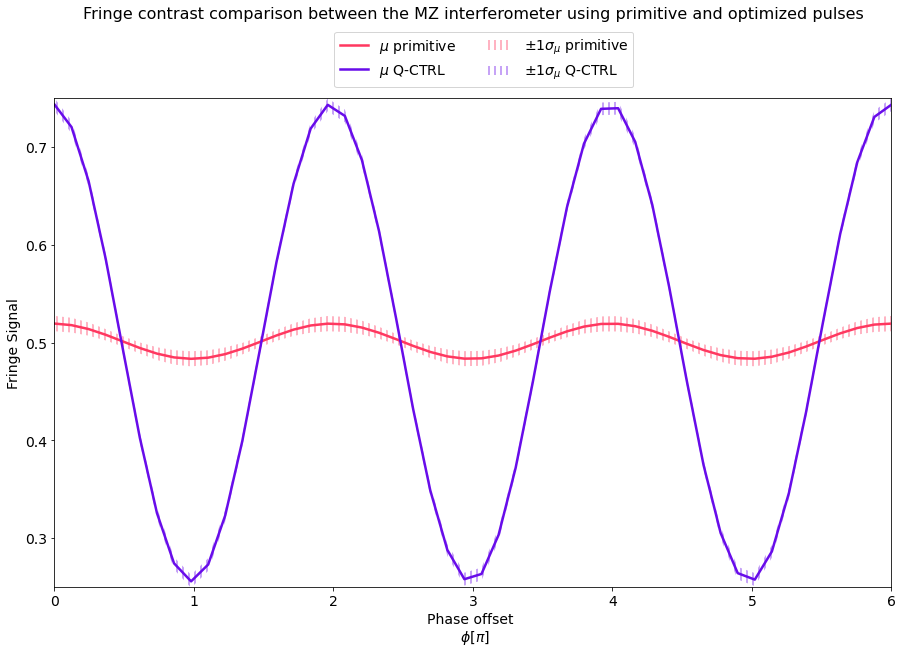

In [10]:
# plotting the fringes
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(15)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.title(
    r"Fringe contrast comparison between the MZ interferometer using primitive and optimized pulses",
    fontsize=16,
    y=1.15,
)
plt.xlabel("Phase offset \n $\phi [\pi]$", fontsize=14)
plt.ylabel("Fringe Signal", fontsize=14)

# plot pz distibution
for idx, scheme in enumerate(schemes):
    x = signal_data[scheme]["phase_offsets"] / (np.pi)
    y = signal_data[scheme]["signal_average"]
    y_std = signal_data[scheme]["standard_error"]
    plt.plot(x, y, "-", linewidth=2.5, color=colours[idx], label=r"$\mu$ " + scheme)
    ax.fill_between(
        x,
        y - y_std,
        y + y_std,
        hatch="||",
        alpha=0.75,
        facecolor="none",
        edgecolor=colours[idx],
        linewidth=0.0,
        label=r"$\pm1\sigma_\mu$ " + scheme,
    )

plt.ylim([0.25, 0.75])
plt.xlim([0, 6])
ax.legend(ncol=2, loc="best", bbox_to_anchor=(0.7, 1.15), fontsize=14)

plt.show()

Ploted above is the average state probability $P_{|1\rangle}$ as a function of the phase offset on the last Beam-Splitter pulse. We see that operating the atom interferometer under high noise conditions using the standard square pulses causes the fringe contrast to suffer significantly under the noise distributions outlined above. In contrast, our robust pulses exhibit ten times greater fringe contrast improvement.